# Fitting complex functions

Python activities to complement [*Measurements and their Uncertainties*](https://www.oupcanada.com/catalog/9780199566334.html) (*MU*), Chapter 6, "Least-squares fitting of complex functions."

* [Preliminaries](#Preliminaries)
* [Linear fits with non-uniform errors](#Linear-fits-with-non-uniform-errors)
    * [Explicit formulas](#Explicit-formulas)
    * [Non-uniform errors with `polyfit`](#Non-uniform-errors-with-polyfit)
* [Residual analysis with non-uniform errors](#Residual-analysis-with-non-uniform-errors)
    * [Exercise 1](#Exercise-1)
* [Polynomial fits](#Polynomial-fits)
* [Least-squares fits that are nonlinear in the parameters](#Least-squares-fits-that-are-nonlinear-in-the-parameters)
    * [Plot the data](#Plot-the-data)
    * [Choose initial parameter values for the fit](#Choose-initial-parameter-values-for-the-fit)
    * [Fit the model to the data and examine the residuals](#Fit-the-model-to-the-data-and-examine-the-residuals)
    * [Exercise 2](#Exercise-2)
* [Summary](#Summary)

## Preliminaries
Before proceeding with this notebook you should review the topics from the [previous notebook](5.0-Visualization-and-modeling.ipynb) (see also the additional notebook on [linear fits and residuals](5.1-Linear-fits.ipynb)) and read *MU* Ch. 6, "Least-squares fitting of complex functions," with the following [goals](A.0-Reading-goals.ipynb#Data-visualization-and-reduction) in mind.

1. Be able to recall and use the *&chi;*<sup>2</sup> goodness-of-fit parameter (6.1) to fit a model to data, including:
    1. determine the best fit parameters by constructing and minimizing *&chi;*<sup>2</sup>;
    2. account for non-uniform uncertainties, for example for measurements drawn from a Poisson distribution; and
    3. recognize the need for the weights in Equations (6.3)-(6.7) for a linear fit with non-uniform uncertainties.
2. Be able to identify measurement strategies that will minimize the uncertainty of a particular fit parameter, for example the slope or the intercept in a linear fit.
3. Recognize the need to use normalized residuals to evaluate fits with non-uniform uncertainties.
4. Recognize the distinction between linear and nonlinear fits; specifically, that:
    1. model functions that are linear in the parameters possess closed-form solutions like Equations (6.3)-(6.7) with a single set of optimal parameters; 
    2. model functions that are nonlinear in the parameters require numerical optimization techniques that are not guaranteed to have a single global solution;
    3. nonlinear fit algorithms require an initial guess for the model parameters, while linear fits do not; and
    4. the initial parameter guess may influence the solution found in a nonlinear fit.
5. Be able to construct contours of the *&chi;*<sup>2</sup> function in a two-parameter fit, and use them to estimate parameter uncertainties.
6. Recognize the value and practical challenge of combining results from different measurements, each fit with different models, but using the same underlying fit parameters, e.g., fitting the complex function (6.15) to measurements of the real and imaginary part of a frequency response.
7. Be able to test for correlations in fit residuals using lag plots and the Durbin-Watson statistic, Eq. (6.16); be able to explain why such correlations may indicate a poor fit of the model to the experimental data.

The following code cell includes previously used initialization commands that we will need here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

%matplotlib inline

## Linear fits with non-uniform errors
### Explicit formulas

Now we consider the general case of the goodness-of-fit statistic,

$$\chi^2(m,c;\{x_k\},\{y_k\},\{\alpha_k\}) = \sum_{k=1}^N\frac{[y_k - (mx_k +  c)]^2}{\alpha_k^2}, \label{eq:lsq}\tag{1}$$

where the errors $\{\alpha_k\}$ are non-uniform. Differentiating with respect to the fit parameters $\{m, c\}$ to find the extremum, we obtain

\begin{align}
\left.\frac{\partial{\chi^2}}{\partial m}\right|_{\hat{m},\hat{c}} &= -2\sum_{k=1}^N[y_k - (\hat{m}x_k + \hat{c})]\,x_k\,\alpha_{k}^{-2} = 0,\\
\left.\frac{\partial{\chi^2}}{\partial c}\right|_{\hat{m},\hat{c}} &= -2\sum_{k=1}^N[y_k - (\hat{m}x_k + \hat{c})]\,\alpha_{k}^{-2} = 0.
\end{align}

We define $w_k = \alpha_k^{-2}$ as the *weight* of point $k$ in the sum; points with larger uncertainty have smaller weight. Solving this system of equations for $\hat{m}$ and $\hat{c}$ give *MU* Eqs.&nbsp;(6.3) and (6.4) (rewritten for consistency with the notation here),

\begin{align}
\hat{c} &= \frac{\left(\sum_k w_k x_k^2\right)\left(\sum_k w_k y_k\right) - \left(\sum_k w_k x_k\right)\left(\sum_k w_k x_k y_k\right)}{\Delta'}, \label{eq:c-hat}\tag{2}\\
\hat{m} &= \frac{\sum_k w_k \sum_k w_k x_k y_k - \left(\sum_k w_k x_k\right)\left(\sum_k w_k y_k\right)}{\Delta'},\quad\text{with}\\
\Delta' &= \sum_k w_k \sum_k w_k x_k^2 - \left(\sum_k w_k x_k\right)^2. \label{eq:m-hat}\tag{3}
\end{align}

Propagating the error as we did for uniform measurement uncertainty, we get the parameter uncertainties

\begin{align}
\alpha_{\hat{m}} &= \sqrt{\frac{\sum_k w_k}{\Delta'}}, & \alpha_{\hat{c}} &= \sqrt{\frac{\sum_{k=1}^N w_k x_k^2}{\Delta'}}. \label{eq:alpha-m-c}\tag{4}
\end{align}

We can demonstrate these computations for the data tabulated in *MU* Exercise 6.1 and shown in Fig. 6.1(d), which is contained in the file [`Example-Data.csv`](data/Example-Data.csv). Compare the results to those for the weighted fits in Fig. 6.2(b) given in *MU* Table 6.1.

Intercept estimate with given uncertainty: (-1 ± 3) mV
Slope estimate with given uncertainty: (2.03 ± 0.05) mV/Hz


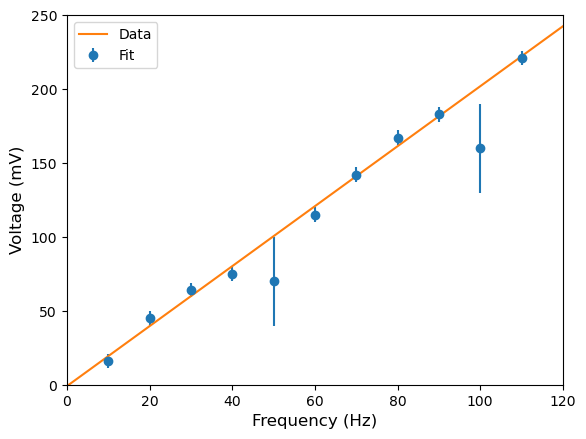

In [2]:
# Load data
frequency, voltage, alpha_voltage = np.genfromtxt("data/Example-Data.csv", skip_header=1, delimiter=",", unpack=True)

# Compute weights and sum over weights
w = 1 / alpha_voltage**2
sw = np.sum(w)

# Weighted sums over x and y
swx = np.sum(w * frequency)
swy = np.sum(w * voltage)

# Weighted sums over x**2 and x*y
swx2 = np.sum(w * frequency**2)
swxy = np.sum(w * frequency * voltage)

# Evaluate Delta'
Delta_prime = sw * swx2 - swx**2

# Put it all together for m_hat and c_hat
c_hat = (swx2 * swy - swx * swxy) / Delta_prime
m_hat = (sw * swxy - swx * swy) / Delta_prime

# Compute standard error for m_hat and c_hat
alpha_c_hat = np.sqrt(swx2 / Delta_prime)
alpha_m_hat = np.sqrt(sw / Delta_prime)

# Print results
print(f"Intercept estimate with given uncertainty: ({c_hat:.0f} ± {alpha_c_hat:.0f}) mV")
print(f"Slope estimate with given uncertainty: ({m_hat:.2f} ± {alpha_m_hat:.2f}) mV/Hz")
print()

# Plot data and fit
frequency_model = np.linspace(0, 120)
plt.errorbar(frequency, voltage, yerr=alpha_voltage, fmt="o")
plt.plot(frequency_model, m_hat * frequency_model + c_hat, "-")

# Format plot
plt.xlim(0, 120)
plt.ylim(0, 250)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Voltage (mV)", fontsize=12)

plt.legend(["Data", "Fit"], fontsize=10)

plt.show()

### Non-uniform errors with `polyfit`

As we saw in the earlier notebook on [linear fits and residuals](5.1-Linear-fits.ipynb), the [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) function includes an optional `w` parameter that allows for non-uniform errors. Note [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) uses a non-standard definition for the weights, `w = 1/alpha_voltage` (the NumPy developers are transitioning to the newer [`Polynomial.fit`](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html#numpy.polynomial.polynomial.Polynomial.fit) class method that will fix this problem, but currently this method lacks the ability to return the parameter covariance matrix, so we will stick with [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)).

The code cell below shows how to use [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) to compute $\hat{m}$, $\hat{c}$, $\alpha_\hat{m}$, and $\alpha_\hat{c}$ for the data in [`Example-Data.csv`](data/Example-Data.csv). Compare with the previous results from the explicit calculation.

In [3]:
# Perform fit
p, V = np.polyfit(frequency, voltage, 1, w=1 / alpha_voltage, cov="unscaled")

# Print results
print(f"Intercept estimate: ({p[1]:.0f} ± {np.sqrt(V[1][1]):.0f}) mV")
print(f"Slope estimate: ({p[0]:.2f} ± {np.sqrt(V[0][0]):.2f}) mV/Hz")

Intercept estimate: (-1 ± 3) mV
Slope estimate: (2.03 ± 0.05) mV/Hz


## Residual analysis with non-uniform errors

As discussed in *MU* Sec. 6.3.2 and shown in *MU* 6.4, it is easier to use normalized residuals to assess the fit quality when the measurement errors are not uniform.

### Exercise 1

In the cell below, copy the residual plot code from the *Example: Residuals for Ohm's law measurement* section of the [linear fits and residuals](5.1-Linear-fits.ipynb) notebook, and modify it to show the fit and normalized residuals for the data in [`Example-Data.csv`](data/Example-Data.csv).

In [4]:
# Code cell for Exercise 1
# Use this cell for your response, adding cells if necessary.

## Polynomial fits

Now let's download another data set from the [NIST Statistical Reference Database](https://www.itl.nist.gov/div898/strd/index.html) and determine a suitable polynomial model for it using the [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) function.

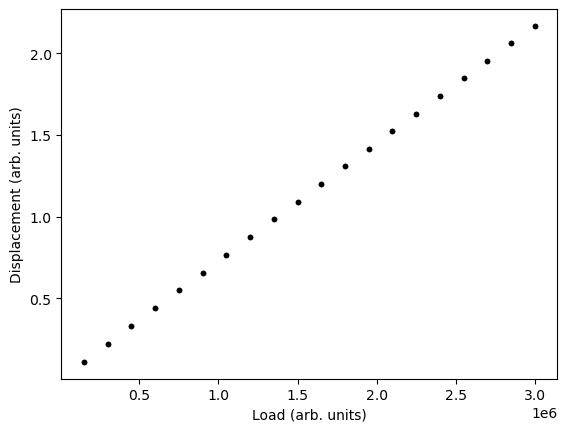

In [5]:
# Load data
disp, load = np.genfromtxt(
    "https://www.itl.nist.gov/div898/strd/lls/data/LINKS/DATA/Pontius.dat", skip_header=60, unpack=True
)

# Plot data
plt.plot(load, disp, "k.")
plt.xlabel("Load (arb. units)")
plt.ylabel("Displacement (arb. units)")
plt.show()

The data looks linear, so we can fit it with a linear model and examine the residuals. Note that we use the [`polyval`](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html) function to evaluate the polynomial with parameters `p` at each value of the `load` variable.

p[0] = (7.221 ± 0.004) x 1e-7
p[1] = (6.1 ± 0.7) x 1e-3


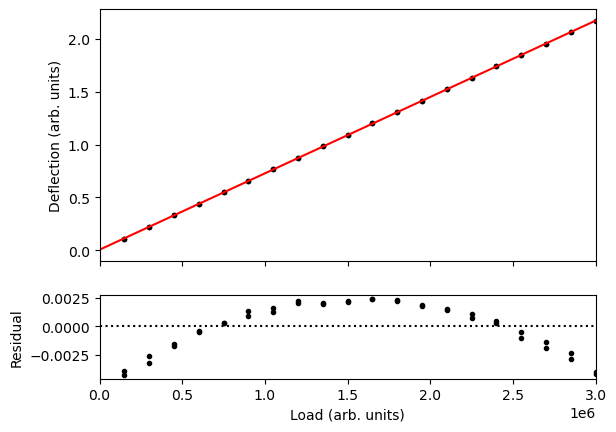

In [6]:
# Perform fit
p, V = np.polyfit(load, disp, 1, cov=True)

# Show optimized fit parameters and uncertainties
print(f"p[0] = ({1e7*p[0]:.3f} ± {1e7*np.sqrt(V[0][0]):.3f}) x 1e-7")
print(f"p[1] = ({1e3*p[1]:.1f} ± {1e3*np.sqrt(V[1][1]):.1f}) x 1e-3")

# Show fit with residuals
# Make a grid with 2 rows, 1 colum, a 3:1 height ratio
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=True, height_ratios=[3, 1])
load_range = [0, np.max(load)]

# Compute the measurement residuals
residuals = disp - np.polyval(p, load)

# Compute the model curve
load_model = np.linspace(load_range[0], load_range[1])
disp_model = np.polyval(p, load_model)

# Make the main plot
axs[0].plot(load, disp, "k.")
axs[0].plot(load_model, disp_model, "r-")
axs[0].set_xlim(load_range[0], load_range[1])
axs[0].set_ylabel("Deflection (arb. units)")

# Make the residual plot with a dotted zero line
axs[1].plot(load, residuals, "k.")
axs[1].plot(load_range, [0, 0], "k:")
axs[1].set_xlim(load_range[0], load_range[1])
axs[1].set_xlabel("Load (arb. units)")
axs[1].set_ylabel("Residual")
plt.show()

The residuals reveal a clear pattern, indicating deviations from linearity that were not evident when we visually inspected the plot. To improve the fit, we can try increasing the polynomial order from 1 to 2. Note that [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) returns polynomial coefficients in decreasing order,

$$
y = a_0 x^p + a_1 x^{p-1} + \ldots + a_{p-1}x + a_p.
$$

As we see below, the residuals for $p=2$ look relatively unstructured, indicating that a 2nd-order polynomial is a satisfactory model for the data.

p2[0] = (-3.16 ± 0.05) x 1e-15
p2[1] = (7.321 ± 0.002) x 1e-7
p2[2] = (0.7 ± 0.1) x 1e-3


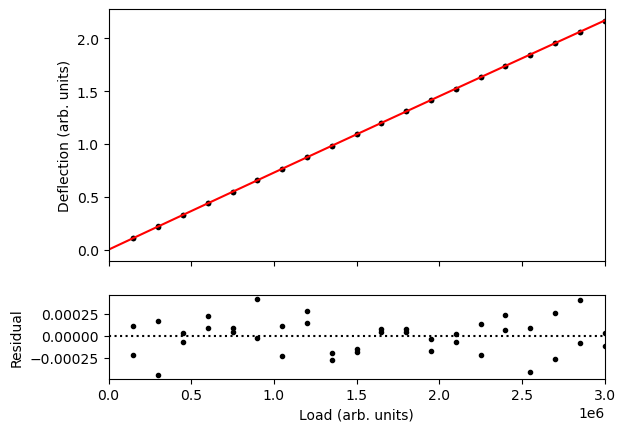

In [7]:
# Perform fit with deg=2
p2, V2 = np.polyfit(load, disp, 2, cov=True)

# Show optimized fit parameters and uncertainties
print(f"p2[0] = ({1e15*p2[0]:.2f} ± {1e15*np.sqrt(V2[0][0]):.2f}) x 1e-15")
print(f"p2[1] = ({1e7*p2[1]:.3f} ± {1e7*np.sqrt(V2[1][1]):.3f}) x 1e-7")
print(f"p2[2] = ({1e3*p2[2]:.1f} ± {1e3*np.sqrt(V2[2][2]):.1f}) x 1e-3")

# Show fit with residuals
# Make a grid with 2 rows, 1 colum, a 3:1 height ratio, and no
# height space between the rows
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=True, height_ratios=[3, 1])
load_range = [0, np.max(load)]

# Compute the measurement residuals
residuals = disp - np.polyval(p2, load)

# Compute the model curve
load_model = np.linspace(load_range[0], load_range[1])
disp_model = np.polyval(p2, load_model)

# Make the main plot
axs[0].plot(load, disp, "k.")
axs[0].plot(load_model, disp_model, "r-")
axs[0].set_xlim(load_range[0], load_range[1])
axs[0].set_ylabel("Deflection (arb. units)")

# Make the residual plot with a dotted zero line
axs[1].plot(load, residuals, "k.")
axs[1].plot(load_range, [0, 0], "k:")
axs[1].set_xlim(load_range[0], load_range[1])
axs[1].set_xlabel("Load (arb. units)")
axs[1].set_ylabel("Residual")

plt.show()

## Least-squares fits that are nonlinear in the parameters

Typically, fitting a model with a nonlinear dependence on one or more of the parameters requires more computational effort than a model that has only linear dependence on the parameters. An example of a nonlinear model is the one for an $LCR$ circuit given by *MU* Eq.&nbsp;(6.11),

$$
V(t) = V_\text{bgd} + V_0\cos\left(\frac{2\pi}{T}t + \phi\right)\exp(-t/\tau).\label{eq:LCR}\tag{1}
$$

This model is *linear* in $V_\text{bgd}$ and $V_0$, but *nonlinear* in $T$, $\phi$, and $\tau$.

To see how we fit such a model to data, we first define a Python function to evaluate Eq.&nbsp;(\ref{eq:LCR}), and use this to simulate measurements that we will then fit with the model.

In [8]:
# Define model


def lcr_model(t, v_bgd, v_0, period, phi, tau):
    return v_bgd + v_0 * np.cos(2 * np.pi * t / period + phi) * np.exp(-t / tau)


# Define time points
t = np.linspace(40, 950, 2000)

# Define model parameters
v_bgd = 0.3
v_0 = 8
period = 39
phi = 4.5
tau = 200

# Define noise amplitude
alpha_v = 0.075

# Simulate data
# Compute ideal values
V_ideal = lcr_model(t, v_bgd, v_0, period, phi, tau)

# Generate noise with amplitude alpha_v
rng = default_rng(0)
V_noise = alpha_v * rng.normal(size=t.size)

# Simulated data is the sum of the ideal values and noise
V_sim = V_ideal + V_noise

### Plot the data

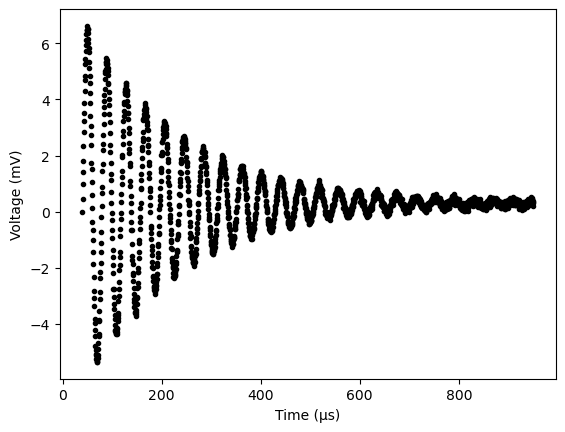

In [9]:
# Plot data
plt.plot(t, V_sim, "k.")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (mV)")
plt.show()

### Choose initial parameter values for the fit

We know the parameters that we used this simulation, but let's determine them from visual inspection of the plot.
1. The background voltage is close to zero, so choose `v_bgd = 0`.
2. Extrapolating the envelope to $t=0$, choose `v_0 = 8`.
3. The circuit oscillates through about four cycles in 200 µs, so choose `period = 50`.
4. The voltage is near zero at $t = 40~\mu\text{s}\approx T$, so choose `phi = 3π/2`.
5. The envelope decays by about $1/e$ after about 250 µs, so choose `tau = 250`.

Compare the model with these parameters to the simulation.

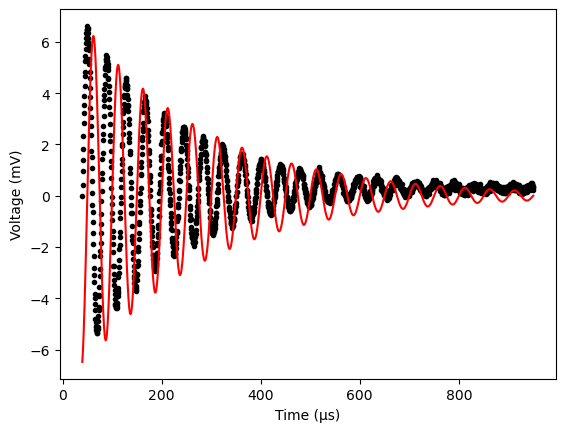

In [10]:
# Assign initial parameters
v_bgd_init = 0
v_0_init = 8
period_init = 50
phi_init = 3 * np.pi / 2
tau_init = 250

# Plot simulation and preliminary model
plt.plot(t, V_sim, "k.")
plt.plot(t, lcr_model(t, v_bgd_init, v_0_init, period_init, phi_init, tau_init), "r-")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (mV)")
plt.show()

### Fit the model to the data and examine the residuals

These parameters do not fit the simulated data very well, but they are close enough for the solver to find a best-fit solution that is close to the simulation. We take `alpha_v` as the measurement uncertainty and set `absolute_sigma=True` to tell the solver that it should assume the uncertainty is known independently when calculating the parameter uncertainties. The value of `v_0_opt` is negative because `phi_opt` is different from `phi_init` by π; otherwise, all the best-fit parameter values are within one standard error of the associated simulation input parameter. We show the fit and the residuals as separate plots here because it is usually better to inspect them both at full scale before combining them in a multipanel figure.

V = 0.2979 ± 0.0017
v_0 = -8.00 ± 0.02
T = 38.994 ± 0.003
phi = 1.355 ± 0.002
tau = 200.0 ± 0.4


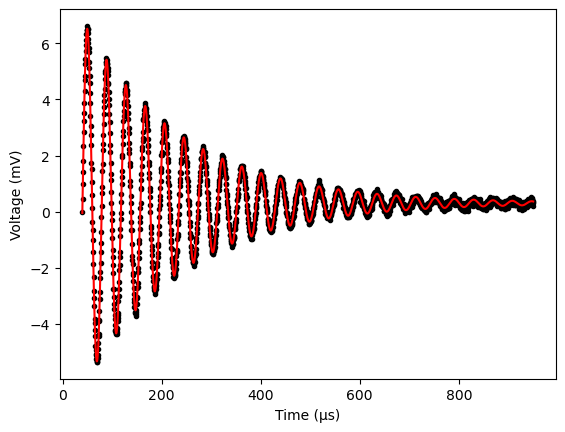

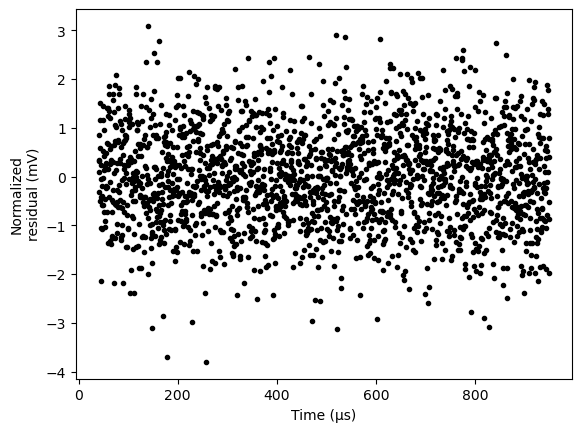

In [11]:
# Fit the model to the data with curve_fit
from scipy.optimize import curve_fit

p_opt, p_cov = curve_fit(
    lcr_model,
    t,
    V_sim,
    p0=[v_bgd_init, v_0_init, period_init, phi_init, tau_init],
    sigma=alpha_v * np.ones(t.size),
    absolute_sigma=True,
)

# Assign each element of p_opt to a named variable
v_bgd_opt = p_opt[0]
v_0_opt = p_opt[1]
period_opt = p_opt[2]
phi_opt = p_opt[3]
tau_opt = p_opt[4]

# Compute the standard errors for the parameters
# by taking the square root of the diagonal elements of p_cov
alpha_vec = np.sqrt(np.diag(p_cov))

# Assign each element of alpha_vec to a named variable
alpha_v_bgd = alpha_vec[0]
alpha_v_0 = alpha_vec[1]
alpha_period = alpha_vec[2]
alpha_phi = alpha_vec[3]
alpha_tau = alpha_vec[4]

# Show optimized fit parameters and uncertainties
print(f"V = {v_bgd_opt:.4f} ± {alpha_v_bgd:.4f}")
print(f"v_0 = {v_0_opt:.2f} ± {alpha_v_0:.2f}")
print(f"T = {period_opt:.3f} ± {alpha_period:.3f}")
print(f"phi = {phi_opt:.3f} ± {alpha_phi:.3f}")
print(f"tau = {tau_opt:.1f} ± {alpha_tau:.1f}")

# Plot data
plt.plot(t, V_sim, "k.")
plt.plot(t, lcr_model(t, v_bgd_opt, v_0_opt, period_opt, phi_opt, tau_opt), "r-")
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (mV)")
plt.show()

# Plot the residuals in a separate figure
plt.plot(t, (V_sim - lcr_model(t, v_bgd_opt, v_0_opt, period_opt, phi_opt, tau_opt)) / alpha_v, "k.")
plt.xlabel("Time (µs)")
plt.ylabel("Normalized\nresidual (mV)")
plt.show()

### Exercise 2

The following cell includes code to import data from the [NIST Statistical Reference Database](https://www.itl.nist.gov/div898/strd/index.html) into the variables `x` and `y` and plots it.

By following the example above, use [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit the following model to the data, assuming that the uncertainty in `y` is uniform with $\alpha = 2.5$.

$$
y(x) = p_0\exp(-p_1 x) + p_2\exp\left[-\frac{(x - p_3)^2}{p_4^2}\right]  + p_5\exp\left[-\frac{(x - p_6)^2}{p_7^2}\right]
$$

Use format strings to display each fit parameter and its uncertainty to the appropriate precision, and plot the fit and the residuals.

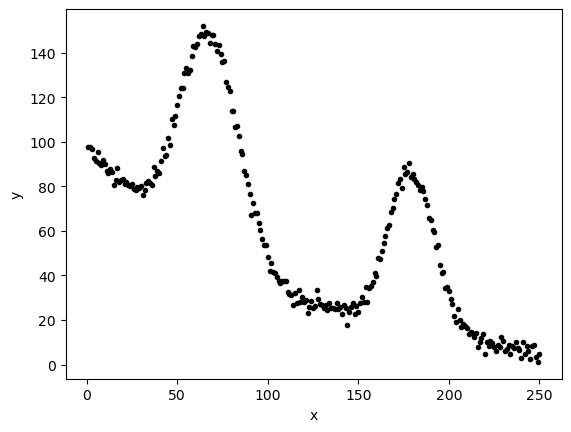

In [12]:
# Code cell for Exercise 2
# Use this cell for your response, adding cells if necessary.

y, x = np.genfromtxt("https://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Gauss1.dat", skip_header=60, unpack=True)
plt.plot(x, y, "k.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Summary
Here is a list of what you should be able to do after completing this notebook.

* Use Eqs.&nbsp;(2)–(4) to compute the parameters and parameter uncertainties of a linear fit when the experimental uncertainty is not uniform.
* Use [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) to compute the parameters and parameter uncertainties of a linear fit when the experimental uncertainty is not uniform.
* [Define a function](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) that represents a theoretical model for experimental results.
* Use [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit a theoretical model to experimental results.
* Interpret and evaluate the results of [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

##### About this notebook
© J. Steven Dodge, 2020. The notebook text is licensed under CC BY 4.0. See more at [Creative Commons](https://creativecommons.org/licenses/by/4.0/). The notebook code is open source under the [MIT License](https://opensource.org/licenses/MIT).